## The solution resistance in mS/cm extracted from the all_Ts_values.csv that has been created from solution_resistance_batch.ipynb and save as csv with similar same format

In [7]:
#!/usr/bin/env python3
"""
Convert every numeric resistance value (Ω) in a CSV to conductivity (mS cm⁻¹)
and save the result as **all_conductivity_values_mScm.csv** in the same folder.

Assumes cell constant K = 1 cm⁻¹   →   σ (mS cm⁻¹) = 1000 / R (Ω)
The column layout is kept identical; only the numeric values change.
"""

import os
import pandas as pd
from pathlib import Path

# 1) -------------- input file ---------------------------------
CSV_PATH = Path(
    "/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/"
    "NPG-500mM-H2SO4-whole/all_Rs_values.csv"
)

# 2) -------------- load ---------------------------------------
df = pd.read_csv(CSV_PATH)

# 3) ---------- convert Ω → mS/cm --------------------------
numeric_cols = df.select_dtypes("number").columns
df[numeric_cols] = 1000.0 / df[numeric_cols].astype(float)

# ---- give each converted column a proper heading ----------
rename_map = {col: col.replace("Rs", "σ").replace("Ω", "mS/cm")
              for col in numeric_cols}
df.rename(columns=rename_map, inplace=True)


# 4) -------------- save with requested name -------------------


# 1) pull the number in front of “mM”, turn into int
df["conc_num"] = df["concentration"].str.extract(r"(\d+)").astype(int)

# 2) (optional) do the same for temperature so 26 C, 28 C … are sorted too
df["temp_num"] = df["temperature"].str.extract(r"(\d+)").astype(int)

# 3) sort first by concentration, then by temperature
df.sort_values(["conc_num", "temp_num"], inplace=True)

# 4) clean-up: drop the helper columns
df.drop(columns=["conc_num", "temp_num"], inplace=True)



out_path = CSV_PATH.with_name("all_conductivity_values_mScm.csv")
df.to_csv(out_path, index=False)

print(f"✓ Conductivity file written to:\n   {out_path}")


✓ Conductivity file written to:
   /Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/all_conductivity_values_mScm.csv


## This snippet takes the conductivity data and searches for the degenracy in conductivity with a given threshold

In [12]:
# ---------------------------------------------------------------
#  Find “degenerate” pairs in conductivity space
#  (|Δσ| ≤ THRESH  AND  conc ≠ conc  AND  temp ≠ temp)
# ---------------------------------------------------------------
from pathlib import Path
import pandas as pd
import itertools

# --- SETTINGS ------------------------------------------------------
CSV_PATH = Path("/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/"
                "NPG-500mM-H2SO4-whole/all_conductivity_values_mScm.csv")
THRESH   = 0.01                 # mS cm⁻¹
OUT_CSV  = CSV_PATH.with_name(f"degenerate_σ_abs<{THRESH}.csv")
# -------------------------------------------------------------------

# --- 1) load -------------------------------------------------------
df = pd.read_csv(CSV_PATH)      # needs: concentration, temperature, σ (mS/cm)

# Accept whatever exact heading the conductivity column has
#   (σ (mS/cm)  or  conductivity (mS/cm) …)
sigma_col = next(c for c in df.columns if "mS/cm" in c)
df.rename(columns={sigma_col: "σ (mS/cm)"}, inplace=True)

rows  = df.to_dict("records")
pairs = itertools.combinations(rows, 2)

# --- 2) build the degenerate-pair list ----------------------------
degenerate = []
for a, b in pairs:
    # skip if conc OR temp is identical
    if a["concentration"] == b["concentration"] or a["temperature"] == b["temperature"]:
        continue

    d_sigma = abs(a["σ (mS/cm)"] - b["σ (mS/cm)"])
    if d_sigma <= THRESH:
        degenerate.append({
            "σ Δ (mS/cm)": d_sigma,
            "conc_T #1":    f"{a['concentration']}, {a['temperature']}",
            "σ #1 (mS/cm)": a["σ (mS/cm)"],
            "conc_T #2":    f"{b['concentration']}, {b['temperature']}",
            "σ #2 (mS/cm)": b["σ (mS/cm)"],
        })

# --- 3) save -------------------------------------------------------
out = (pd.DataFrame(degenerate)
         .sort_values("σ Δ (mS/cm)")
         .reset_index(drop=True))

out.to_csv(OUT_CSV, index=False)

print(f"✓ {len(out)} dissimilar-C&T pairs found (|Δσ| ≤ {THRESH} mS cm⁻¹)")
print(f"  saved to: {OUT_CSV}")
print(out.head(10))


✓ 11 dissimilar-C&T pairs found (|Δσ| ≤ 0.01 mS cm⁻¹)
  saved to: /Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/degenerate_σ_abs<0.01.csv
   σ Δ (mS/cm)  conc_T #1  σ #1 (mS/cm)  conc_T #2  σ #2 (mS/cm)
0     0.001411  14mM, 34C     20.314770  15mM, 28C     20.316181
1     0.001956  11mM, 48C     18.100066  13mM, 28C     18.102022
2     0.002988  15mM, 48C     23.760602  18mM, 28C     23.763590
3     0.005783  19mM, 40C     27.563123  20mM, 36C     27.568906
4     0.006619  15mM, 48C     23.760602  17mM, 34C     23.753983
5     0.007277  12mM, 48C     19.961647  14mM, 32C     19.954370
6     0.007372  10mM, 36C     15.395275  11mM, 26C     15.387904
7     0.007698  14mM, 46C     22.235349  15mM, 38C     22.243047
8     0.008107  14mM, 40C     21.373956  16mM, 28C     21.365848
9     0.009607  17mM, 34C     23.753983  18mM, 28C     23.763590


## This does the same thing as the previous code, but for a different data structure given by the cell constant calculation from Darling. You can also choose how much the error should be in poercentage from Darlings model

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Find degeneracies from corrected conductivity (sigma_corr_mS_per_cm),
while (a) preserving the original degeneracy file structure, and
(b) filtering to only include rows with |relative error| <= MAX_REL_ERROR_PERCENT.

Threshold behavior is configurable:
  - "from_template_max": reuse the max of 'σ Δ (mS/cm)' from the template
  - "fixed": use FIXED_THRESHOLD_MS_PER_CM

Output file name is derived from the template unless OUT_CSV is set.
"""

# =========================
# ======== CONFIG =========
# =========================
DATA_CSV = r"/Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/results/all_data_corrected_C789.csv"         # must include: C_mM, T_C, sigma_corr_mS_per_cm, and either rel_error_% or σ_pred (mS/cm)
TEMPLATE_CSV = r"/Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/results/degenerate_σ_abs<0.01.csv"    # used for structure + (optionally) threshold
OUT_CSV = None                                             # None -> write next to template with informative suffix; or set a path string
                                      # None -> write next to template with informative suffix; or set a path string

# threshold behavior
THRESHOLD_MODE = "from_template_max"   # "from_template_max" or "fixed"
FIXED_THRESHOLD_MS_PER_CM = 0.005       # used only if THRESHOLD_MODE == "fixed"

# filter on per-point relative error
MAX_REL_ERROR_PERCENT = 7.31          # keep only rows with |relative error| <= this

# label for (C,T)
LABEL_FORMAT = "{C:d}mM, {T:d}C"

# pair constraint: (C,T) must differ on BOTH axes
REQUIRE_DISTINCT_C_AND_T = True        # True => enforce C_i != C_j AND T_i != T_j

# how to compare C and T for equality
COMPARE_C_T_AS_INTS = True             # True => round to nearest int for equality checks (matches label style)
EPS_C = 0.0                            # only used if COMPARE_C_T_AS_INTS == False; consider C equal if |ΔC| <= EPS_C
EPS_T = 0.0                            # only used if COMPARE_C_T_AS_INTS == False; consider T equal if |ΔT| <= EPS_T

# =========================
# ========== CODE =========
# =========================
from __future__ import annotations
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Tuple, Optional

def _require_columns(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def _infer_rel_error(df: pd.DataFrame) -> np.ndarray:
    """
    Return relative error (%) per row.
    Priority: existing 'rel_error_%'.
    Fallback: compute from 'sigma_corr_mS_per_cm' and 'σ_pred (mS/cm)'.
    """
    if "rel_error_%" in df.columns:
        return pd.to_numeric(df["rel_error_%"], errors="coerce").to_numpy(dtype=float)

    pred_col = "σ_pred (mS/cm)"
    if pred_col in df.columns:
        sig_corr = pd.to_numeric(df["sigma_corr_mS_per_cm"], errors="coerce").to_numpy(dtype=float)
        pred = pd.to_numeric(df[pred_col], errors="coerce").to_numpy(dtype=float)
        den = np.where(np.abs(pred) < 1e-12, np.nan, pred)
        return 100.0 * (sig_corr - pred) / den

    raise ValueError("No 'rel_error_%' column and no 'σ_pred (mS/cm)' to compute it from.")

def _choose_threshold(template: pd.DataFrame, mode: str, fixed_value: float) -> float:
    if mode == "fixed":
        return float(fixed_value)
    if "σ Δ (mS/cm)" not in template.columns:
        raise ValueError("Template must include 'σ Δ (mS/cm)' column for 'from_template_max' mode.")
    return float(pd.to_numeric(template["σ Δ (mS/cm)"], errors="coerce").max())

def _make_labels(C: np.ndarray, T: np.ndarray, fmt: str) -> np.ndarray:
    Cint = np.rint(C).astype(int)
    Tint = np.rint(T).astype(int)
    return np.array([fmt.format(C=int(c), T=int(t)) for c, t in zip(Cint, Tint)])

def _pairwise_degeneracies(
    df_filt: pd.DataFrame,
    threshold: float,
    label_fmt: str,
    pred_col_name: Optional[str] = "σ_pred (mS/cm)",
    require_distinct_c_and_t: bool = True,
    compare_as_ints: bool = True,
    eps_c: float = 0.0,
    eps_t: float = 0.0,
) -> pd.DataFrame:
    """
    Build all unordered pairs where |Δsigma_corr| <= threshold, optionally requiring both C and T to differ.
    Returns columns like the template PLUS Darling values for each endpoint:

      'σ Δ (mS/cm)', 'conc_T #1', 'σ #1 (mS/cm)',
      'conc_T #2',   'σ #2 (mS/cm)',
      'σ_pred #1 (mS/cm)', 'σ_pred #2 (mS/cm)'
    """
    s_corr = pd.to_numeric(df_filt["sigma_corr_mS_per_cm"], errors="coerce").to_numpy(dtype=float)
    C = pd.to_numeric(df_filt["C_mM"], errors="coerce").to_numpy(dtype=float)
    T = pd.to_numeric(df_filt["T_C"], errors="coerce").to_numpy(dtype=float)
    labels = _make_labels(C, T, label_fmt)

    # Optional predicted (Darling) values
    if (pred_col_name is not None) and (pred_col_name in df_filt.columns):
        s_pred = pd.to_numeric(df_filt[pred_col_name], errors="coerce").to_numpy(dtype=float)
    else:
        s_pred = np.full_like(s_corr, np.nan, dtype=float)

    n = len(df_filt)
    if n < 2:
        return pd.DataFrame(columns=[
            "σ Δ (mS/cm)", "conc_T #1", "σ #1 (mS/cm)",
            "conc_T #2", "σ #2 (mS/cm)",
            "σ_pred #1 (mS/cm)", "σ_pred #2 (mS/cm)"
        ])

    # Pair indices
    i_idx, j_idx = np.triu_indices(n, k=1)
    delta = np.abs(s_corr[i_idx] - s_corr[j_idx])
    keep = delta <= float(threshold)

    # Enforce distinct C and T if requested
    if require_distinct_c_and_t:
        if compare_as_ints:
            Ci = np.rint(C[i_idx]).astype(int)
            Cj = np.rint(C[j_idx]).astype(int)
            Ti = np.rint(T[i_idx]).astype(int)
            Tj = np.rint(T[j_idx]).astype(int)
            diff_ct = (Ci != Cj) & (Ti != Tj)
        else:
            diff_ct = (np.abs(C[i_idx] - C[j_idx]) > float(eps_c)) & \
                      (np.abs(T[i_idx] - T[j_idx]) > float(eps_t))
        keep = keep & diff_ct

    # Build output
    out = pd.DataFrame({
        "σ Δ (mS/cm)": delta[keep],
        "conc_T #1": labels[i_idx[keep]],
        "σ #1 (mS/cm)": s_corr[i_idx[keep]],
        "conc_T #2": labels[j_idx[keep]],
        "σ #2 (mS/cm)": s_corr[j_idx[keep]],
        "σ_pred #1 (mS/cm)": s_pred[i_idx[keep]],
        "σ_pred #2 (mS/cm)": s_pred[j_idx[keep]],
    })

    # Stable sort for reproducibility
    out = out.sort_values(by=["σ Δ (mS/cm)", "conc_T #1", "conc_T #2"],
                          ascending=[True, True, True],
                          kind="mergesort").reset_index(drop=True)
    return out

def run(data_csv: str | Path,
        template_csv: str | Path,
        out_csv: str | Path | None = None,
        threshold_mode: str = THRESHOLD_MODE,
        fixed_threshold_ms_per_cm: float = FIXED_THRESHOLD_MS_PER_CM,
        max_rel_error_percent: float = MAX_REL_ERROR_PERCENT,
        label_fmt: str = LABEL_FORMAT,
        require_distinct_c_and_t: bool = REQUIRE_DISTINCT_C_AND_T,
        compare_as_ints: bool = COMPARE_C_T_AS_INTS,
        eps_c: float = EPS_C,
        eps_t: float = EPS_T) -> Tuple[float, int, Path]:
    """
    Returns
    -------
    (threshold_mS_per_cm, n_pairs, out_path)
    """
    data_csv = Path(data_csv)
    template_csv = Path(template_csv)

    data = pd.read_csv(data_csv)
    template = pd.read_csv(template_csv)

    # Ensure required columns are present
    _require_columns(data, ["C_mM", "T_C", "sigma_corr_mS_per_cm"])

    # Determine threshold
    threshold = _choose_threshold(template, mode=threshold_mode, fixed_value=fixed_threshold_ms_per_cm)

    # Relative error & filter
    rel = _infer_rel_error(data)
    data = data.copy()
    data["_rel_err_%"] = rel
    keep = np.isfinite(data["_rel_err_%"]) & (np.abs(data["_rel_err_%"]) <= float(max_rel_error_percent))

    # Keep predicted if present for later output
    cols = ["C_mM", "T_C", "sigma_corr_mS_per_cm"]
    if "σ_pred (mS/cm)" in data.columns:
        cols.append("σ_pred (mS/cm)")

    df_filt = data.loc[keep, cols].dropna(subset=["C_mM", "T_C", "sigma_corr_mS_per_cm"]).reset_index(drop=True)

    # Degenerate pairs (with Darling columns if available), enforcing distinct C and T
    out = _pairwise_degeneracies(
        df_filt,
        threshold=threshold,
        label_fmt=label_fmt,
        pred_col_name="σ_pred (mS/cm)",
        require_distinct_c_and_t=require_distinct_c_and_t,
        compare_as_ints=compare_as_ints,
        eps_c=eps_c,
        eps_t=eps_t,
    )

    # Output path
    if out_csv is None:
        suffix = f"_from_sigma_corr_maxerr{int(round(max_rel_error_percent))}"
        if require_distinct_c_and_t:
            suffix += "_ctdiff"
        if threshold_mode == "fixed":
            suffix += f"_thr{fixed_threshold_ms_per_cm:g}"
        out_csv = template_csv.with_name(f"{template_csv.stem}{suffix}.csv")
    out_path = Path(out_csv)
    out.to_csv(out_path, index=False)

    return threshold, len(out), out_path

# -------------- CLI --------------
if __name__ == "__main__":
    thr, n_pairs, outp = run(
        DATA_CSV,
        TEMPLATE_CSV,
        OUT_CSV,
        threshold_mode=THRESHOLD_MODE,
        fixed_threshold_ms_per_cm=FIXED_THRESHOLD_MS_PER_CM,
        max_rel_error_percent=MAX_REL_ERROR_PERCENT,
        label_fmt=LABEL_FORMAT,
        require_distinct_c_and_t=REQUIRE_DISTINCT_C_AND_T,
        compare_as_ints=COMPARE_C_T_AS_INTS,
        eps_c=EPS_C,
        eps_t=EPS_T,
    )
    print(f"Threshold used: {thr:.6g} mS/cm  (mode = {THRESHOLD_MODE})")
    print(f"Degenerate pairs found (|rel error| <= {MAX_REL_ERROR_PERCENT:.1f}%, distinct C & T = {REQUIRE_DISTINCT_C_AND_T}): {n_pairs}")
    print("Wrote:", outp)


Threshold used: 0.00982014 mS/cm  (mode = from_template_max)
Degenerate pairs found (|rel error| <= 7.3%, distinct C & T = True): 13
Wrote: /Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/results/degenerate_σ_abs<0.01_from_sigma_corr_maxerr7_ctdiff.csv


## This snippet makes a plot from the degenerate data

<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:128: SyntaxWarning: invalid escape sequence '\m'
/var/folders/f8/_pjxj9td0yv8g2ys5m4mw42c0000gn/T/ipykernel_3520/2182113007.py:106: SyntaxWarning: invalid escape sequence '\D'
  "Degenerate $(C,T)$ Pairs with $\Delta \sigma<10 $ $\mu S$ $cm^{-1}$",
/var/folders/f8/_pjxj9td0yv8g2ys5m4mw42c0000gn/T/ipykernel_3520/2182113007.py:128: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label("|Δσ|  [$\mu S$ cm$^{-1}$]")


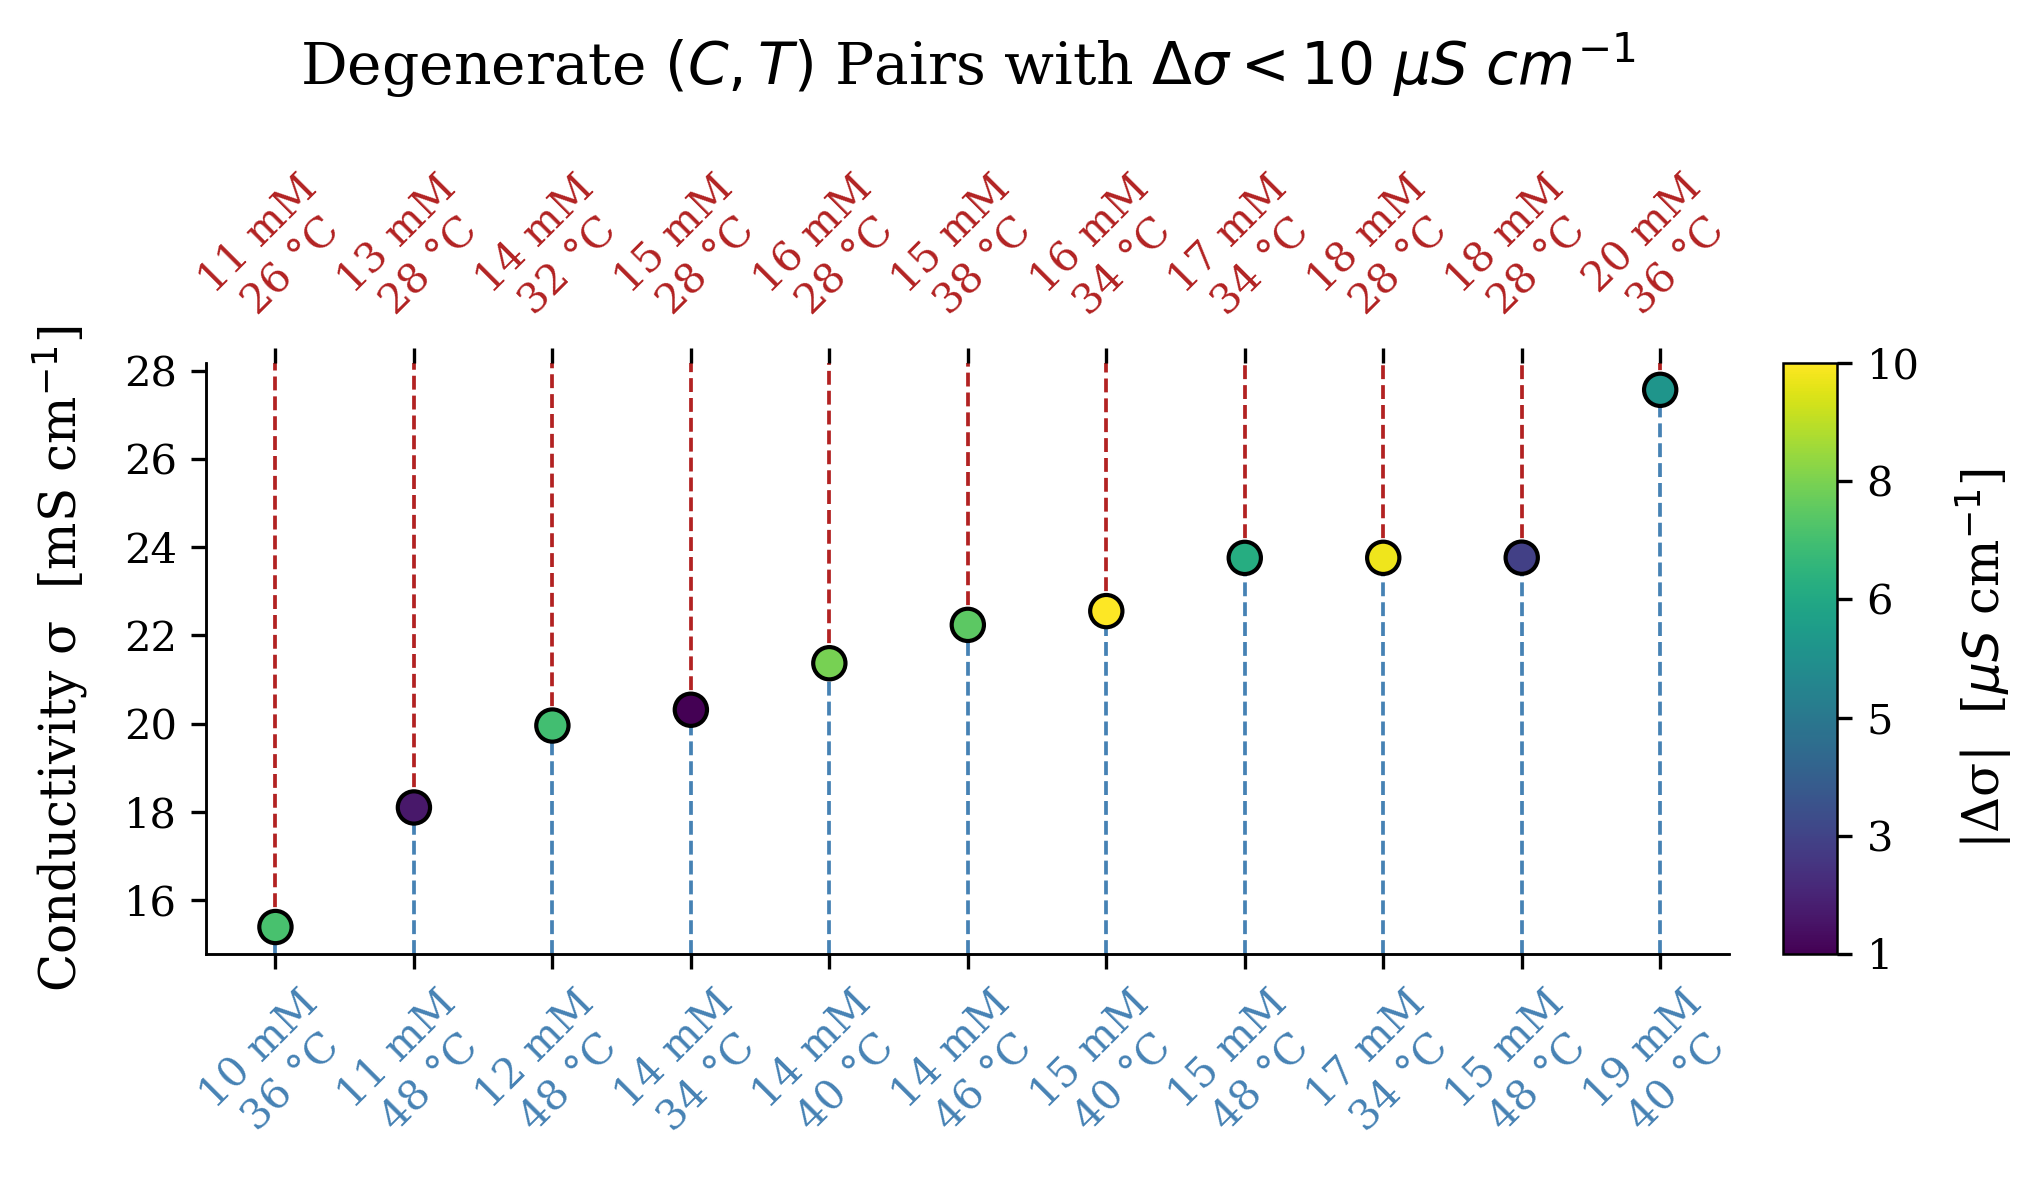

In [ ]:
from pathlib import Path

# ---------------------------------------------------------------
#  Plot mean conductivity (left-axis) coloured by |Δσ|
# ---------------------------------------------------------------
CSV = ("/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole/degenerate_σ_abs<0.01.csv")  

OUT_DIR = Path(r"/Volumes/01785304894/Uni Stuff/Measurement_Data/2025/June-July/NPG-500mM-H2SO4-whole")   #
OUT_DIR.mkdir(parents=True, exist_ok=True)
THRESH   = 0.01 

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'serif',       # default Times-like; comment if journal provides style
    'font.size': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.linewidth': 0.6,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 12,   # default label font
    'axes.labelpad': 8,     # default gap (points)
})


# ------------------ 1. load & parse ------------------
df = pd.read_csv(CSV)
df.columns = [c.strip() for c in df.columns]

def _parse_ct(text):
    """ '14mM, 32C'  -->  (14, 32) """
    m = re.match(r"\s*(\d+)\s*mM,\s*(\d+)\s*C", str(text))
    return (int(m.group(1)), int(m.group(2))) if m else (np.nan, np.nan)

# split concentration / temperature out for nicer tick labels
df[["C1","T1"]] = df["conc_T #1"].apply(lambda s: pd.Series(_parse_ct(s)))
df[["C2","T2"]] = df["conc_T #2"].apply(lambda s: pd.Series(_parse_ct(s)))

# convenience names – may differ if you changed headings earlier
d_sigma = df["σ Δ (mS/cm)"].values
sigma1  = df["σ #1 (mS/cm)"].values
sigma2  = df["σ #2 (mS/cm)"].values
sigma_avg = (sigma1 + sigma2) / 2        # left-axis data

# optional: sort by |Δσ| so the most similar pairs come first
df["σ̅"] = sigma_avg
df.sort_values("σ Δ (mS/cm)", inplace=True, ignore_index=True)

# ------------------ 2. make the plot ------------------
df["σ̅"] = (df["σ #1 (mS/cm)"] + df["σ #2 (mS/cm)"]) / 2
df.sort_values("σ̅", inplace=True, ignore_index=True)

# ------------------ build & decorate the plot ------------------
x = np.arange(len(df))
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

sc = ax.scatter(
    x, df["σ̅"],
    c=df["σ Δ (mS/cm)"],
    cmap="viridis",
    ec="black",
    s=60,
    zorder=3,
)

ax.set_ylabel("Conductivity σ  [mS cm$^{-1}$]")
ax.set_xticks(x)
ax.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C1"], df["T1"])],
    rotation=45, ha="right", color="steelblue",
)

# ---------- top x-axis ----------
ax_top = ax.twiny()
ax_top.set_xticks(x)

ax.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C1"], df["T1"])],
    rotation=45, ha="center", color="steelblue"
)

ax_top.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C2"], df["T2"])],
    rotation=45, ha="center", color="firebrick"
)

ax_top.xaxis.set_ticks_position("top")

# ---------- guide lines ----------
ax.set_xlim(-0.5, len(df) - 0.5)      # centres ticks & guides
ax_top.set_xlim(ax.get_xlim())

ymin, ymax = ax.get_ylim()
for xi, yi in zip(x, df["σ̅"]):
    ax.plot([xi, xi], [ymin, yi], ls="--", lw=0.9, color="steelblue",  zorder=0)
    ax.plot([xi, xi], [yi, ymax], ls="--", lw=0.9, color="firebrick", zorder=0)
ax.set_ylim(ymin, ymax)

ax.set_title(
    "Degenerate $(C,T)$ Pairs with $\Delta \sigma<10 $ $\mu S$ $cm^{-1}$",
    fontsize=14,   # points
    pad=20         # points of extra space between title and axes frame
)

#ax.grid(axis="y", ls="--", alpha=0.4)

# ---------- run tight_layout *before* placing colour-bar ----------
fig.tight_layout()

# ---------- colour-bar outside, full plot height ----------
CBAR_WIDTH = 0.03   # fraction of figure width
CBAR_PAD   = 0.03   # horizontal gap (fraction)

pos   = ax.get_position()               # updated position after tight_layout
bar_x0 = pos.x1 + CBAR_PAD              # right of frame
bar_y0 = pos.y0                         # same bottom
bar_h  = pos.height                     # same height

cax  = fig.add_axes([bar_x0, bar_y0, CBAR_WIDTH, bar_h])
cbar = fig.colorbar(sc, cax=cax)

cbar.set_label("|Δσ|  [$\mu S$ cm$^{-1}$]")

# after you have created `cbar` …
vmin, vmax = df["σ Δ (mS/cm)"].min(), df["σ Δ (mS/cm)"].max()

# choose how many ticks you’d like (4-6 usually looks good)
N_TICKS = 6
tick_vals = np.linspace(vmin, vmax, N_TICKS)

cbar.set_ticks(tick_vals)
cbar.set_ticklabels([f"{v*1000:.0f}" for v in tick_vals])   # → 0.002, 0.004, …



fname = OUT_DIR / f"degenerate_Rs_pairs_thresh{THRESH:.3f}Ω.png"
fig.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()



## This one the Colorbar is in percentage

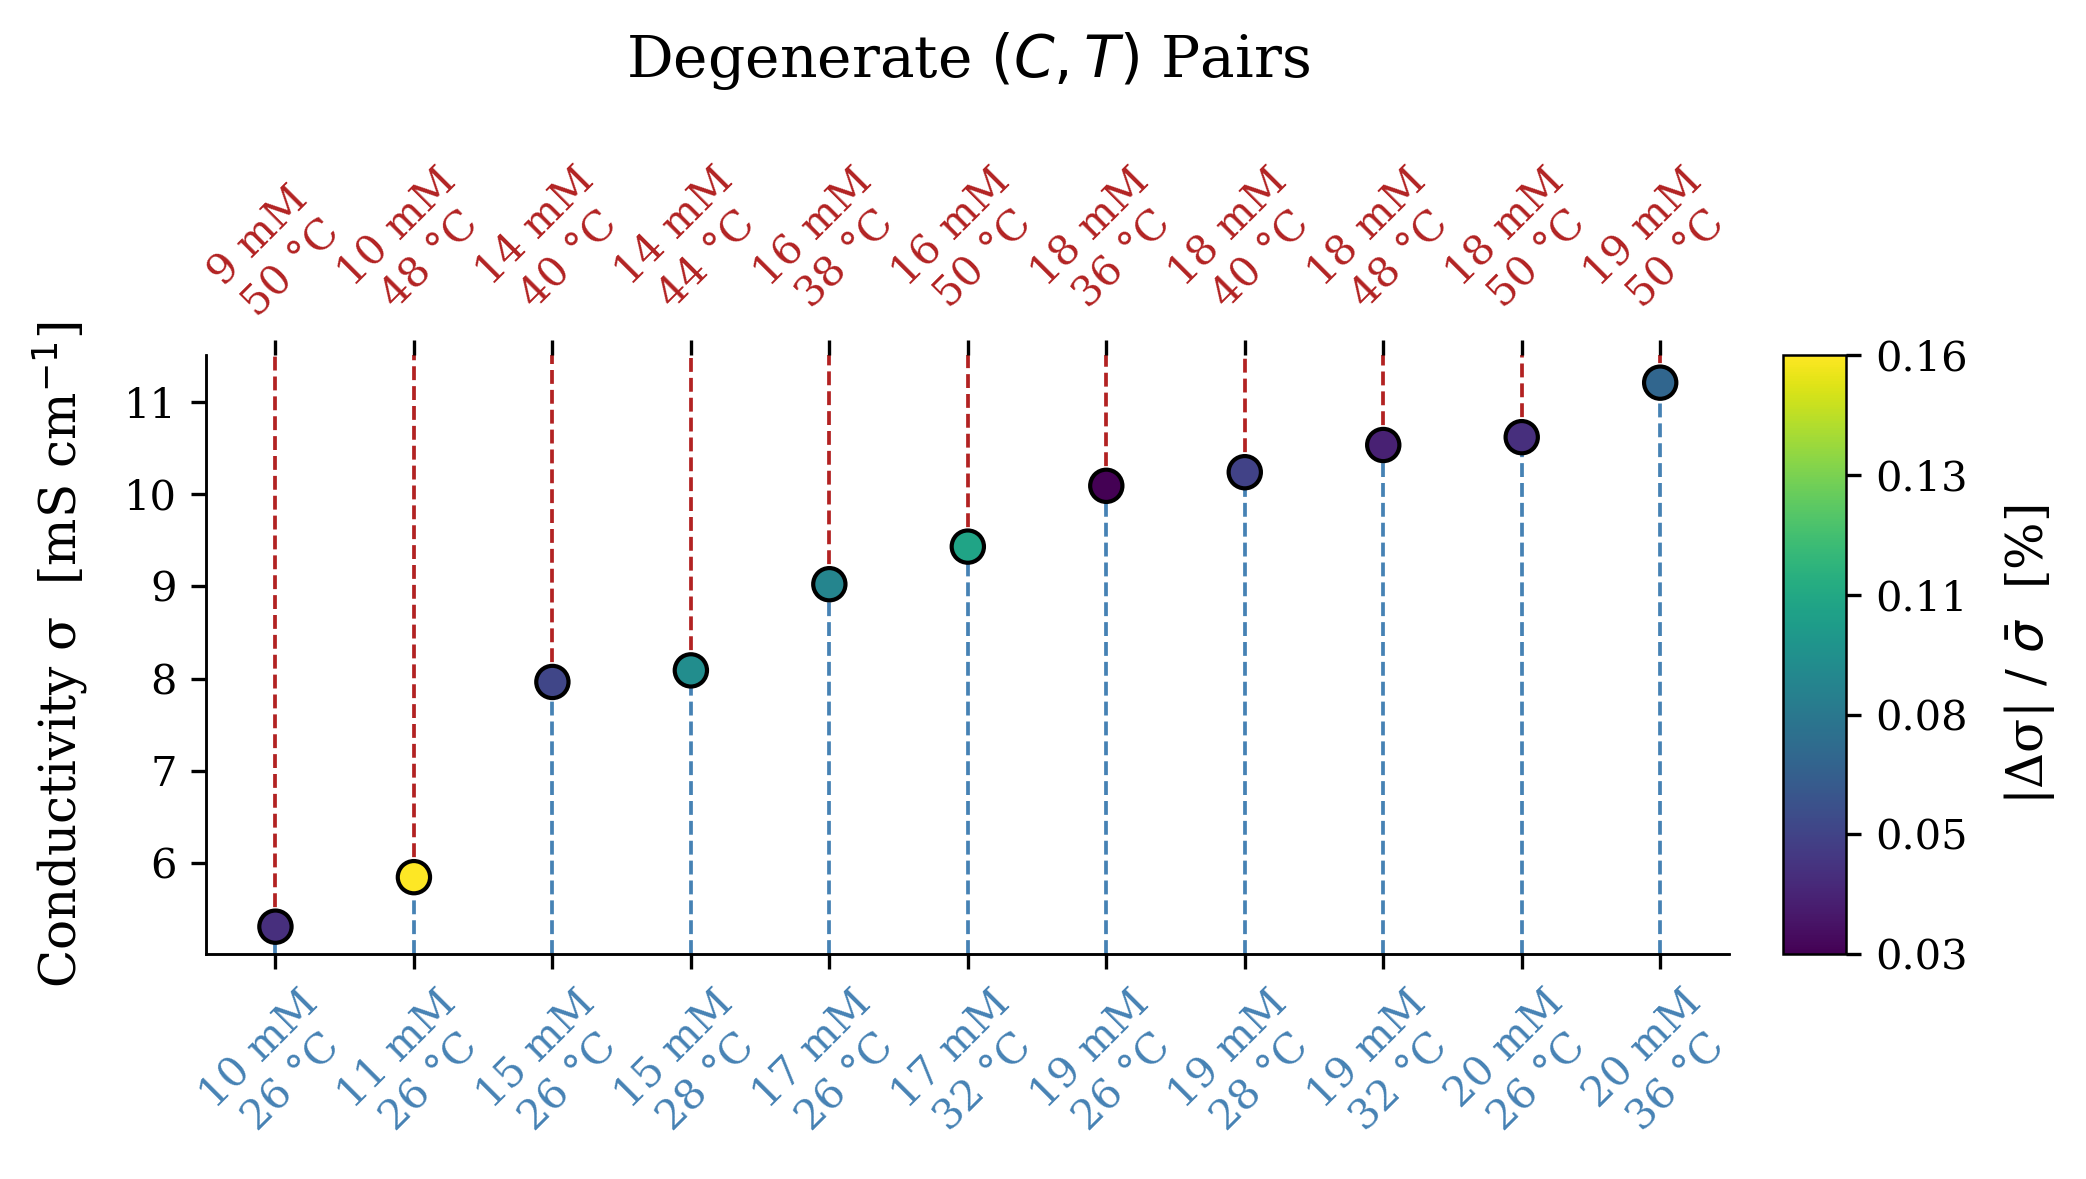

In [5]:
from pathlib import Path

# ---------------------------------------------------------------
#  Plot mean conductivity (left-axis) coloured by |Δσ|
# ---------------------------------------------------------------
CSV = ("/Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/results/degenerate_σ_absANCHOR.csv")  

OUT_DIR = Path(r"/Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/plots")   
OUT_DIR.mkdir(parents=True, exist_ok=True)
THRESH   = 0.01 

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'serif',       # default Times-like; comment if journal provides style
    'font.size': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.linewidth': 0.6,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 12,   # default label font
    'axes.labelpad': 8,     # default gap (points)
})


# ------------------ 1. load & parse ------------------
df = pd.read_csv(CSV)
df.columns = [c.strip() for c in df.columns]

def _parse_ct(text):
    """ '14mM, 32C'  -->  (14, 32) """
    m = re.match(r"\s*(\d+)\s*mM,\s*(\d+)\s*C", str(text))
    return (int(m.group(1)), int(m.group(2))) if m else (np.nan, np.nan)

# split concentration / temperature out for nicer tick labels
df[["C1","T1"]] = df["conc_T #1"].apply(lambda s: pd.Series(_parse_ct(s)))
df[["C2","T2"]] = df["conc_T #2"].apply(lambda s: pd.Series(_parse_ct(s)))

# convenience names – may differ if you changed headings earlier
d_sigma = df["σ Δ (mS/cm)"].values
sigma1  = df["σ #1 (mS/cm)"].values
sigma2  = df["σ #2 (mS/cm)"].values
sigma_avg = (sigma1 + sigma2) / 2        # left-axis data

# optional: sort by |Δσ| so the most similar pairs come first
df["σ̅"] = sigma_avg
df.sort_values("σ Δ (mS/cm)", inplace=True, ignore_index=True)

df["rel_dev"] = df["σ Δ (mS/cm)"].abs() / df["σ̅"]      # 0–1 range
df["rel_dev"] *= 100                                  # uncomment → %

# ------------------ 2. make the plot ------------------
df["σ̅"] = (df["σ #1 (mS/cm)"] + df["σ #2 (mS/cm)"]) / 2
df.sort_values("σ̅", inplace=True, ignore_index=True)

# ------------------ build & decorate the plot ------------------
x = np.arange(len(df))
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

sc = ax.scatter(
    x, df["σ̅"],
    c=df["rel_dev"],          #  ⬅️  use the new column
    cmap="viridis",
    ec="black",
    s=60,
    zorder=3,
)


ax.set_ylabel("Conductivity σ  [mS cm$^{-1}$]")
ax.set_xticks(x)
ax.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C1"], df["T1"])],
    rotation=45, ha="right", color="steelblue",
)

# ---------- top x-axis ----------
ax_top = ax.twiny()
ax_top.set_xticks(x)

ax.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C1"], df["T1"])],
    rotation=45, ha="center", color="steelblue"
)

ax_top.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C2"], df["T2"])],
    rotation=45, ha="center", color="firebrick"
)

ax_top.xaxis.set_ticks_position("top")

# ---------- guide lines ----------
ax.set_xlim(-0.5, len(df) - 0.5)      # centres ticks & guides
ax_top.set_xlim(ax.get_xlim())

ymin, ymax = ax.get_ylim()
for xi, yi in zip(x, df["σ̅"]):
    ax.plot([xi, xi], [ymin, yi], ls="--", lw=0.9, color="steelblue",  zorder=0)
    ax.plot([xi, xi], [yi, ymax], ls="--", lw=0.9, color="firebrick", zorder=0)
ax.set_ylim(ymin, ymax)

ax.set_title(
    "Degenerate $(C,T)$ Pairs", #with $\Delta \sigma<10 $ $\mu S$ $cm^{-1}$",
    fontsize=14,   # points
    pad=20         # points of extra space between title and axes frame
)

#ax.grid(axis="y", ls="--", alpha=0.4)

# ---------- run tight_layout *before* placing colour-bar ----------
fig.tight_layout()

# ---------- colour-bar outside, full plot height ----------
# ---------- colour-bar outside, adjustable height ----------
CBAR_WIDTH  = 0.035   # fraction of figure width
CBAR_PAD    = 0.03   # horizontal gap
CBAR_HFRAC  = 1.0   # 0.70 → 70 % of plot height   ← adjust here

pos = ax.get_position()                     # after tight_layout
bar_x0 = pos.x1 + CBAR_PAD
bar_h  = pos.height * CBAR_HFRAC            # shorter bar
bar_y0 = pos.y0 + (pos.height - bar_h)/2    # centred vertically
# use bar_y0 = pos.y0          # <- flush bottom
# use bar_y0 = pos.y1 - bar_h  # <- flush top

cax  = fig.add_axes([bar_x0, bar_y0, CBAR_WIDTH, bar_h])
cbar = fig.colorbar(sc, cax=cax)

cbar.set_label(r'|Δσ| / $ \bar{\sigma}$  [%]')   # or '% deviation' if you used ×100

vmin, vmax = df["rel_dev"].min(), df["rel_dev"].max()
N_TICKS = 6
tick_vals = np.linspace(vmin, vmax, N_TICKS)

if vmax < 0.2:                   # example: switch to % only if small
    fmt = "{:.2f}"               # 0.03, 0.06 …
else:
    fmt = "{:.1f}"

cbar.set_ticks(tick_vals)
cbar.set_ticklabels([fmt.format(v*100 if fmt.endswith('%') else v)
                     for v in tick_vals])


fname = OUT_DIR / f"degenerate_sigma_pairs_thresh{THRESH:.3f}Ω_relative_CELLConstant.png"
fig.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()



## This code plots the difference between the cell constant applied data and the Darlings report

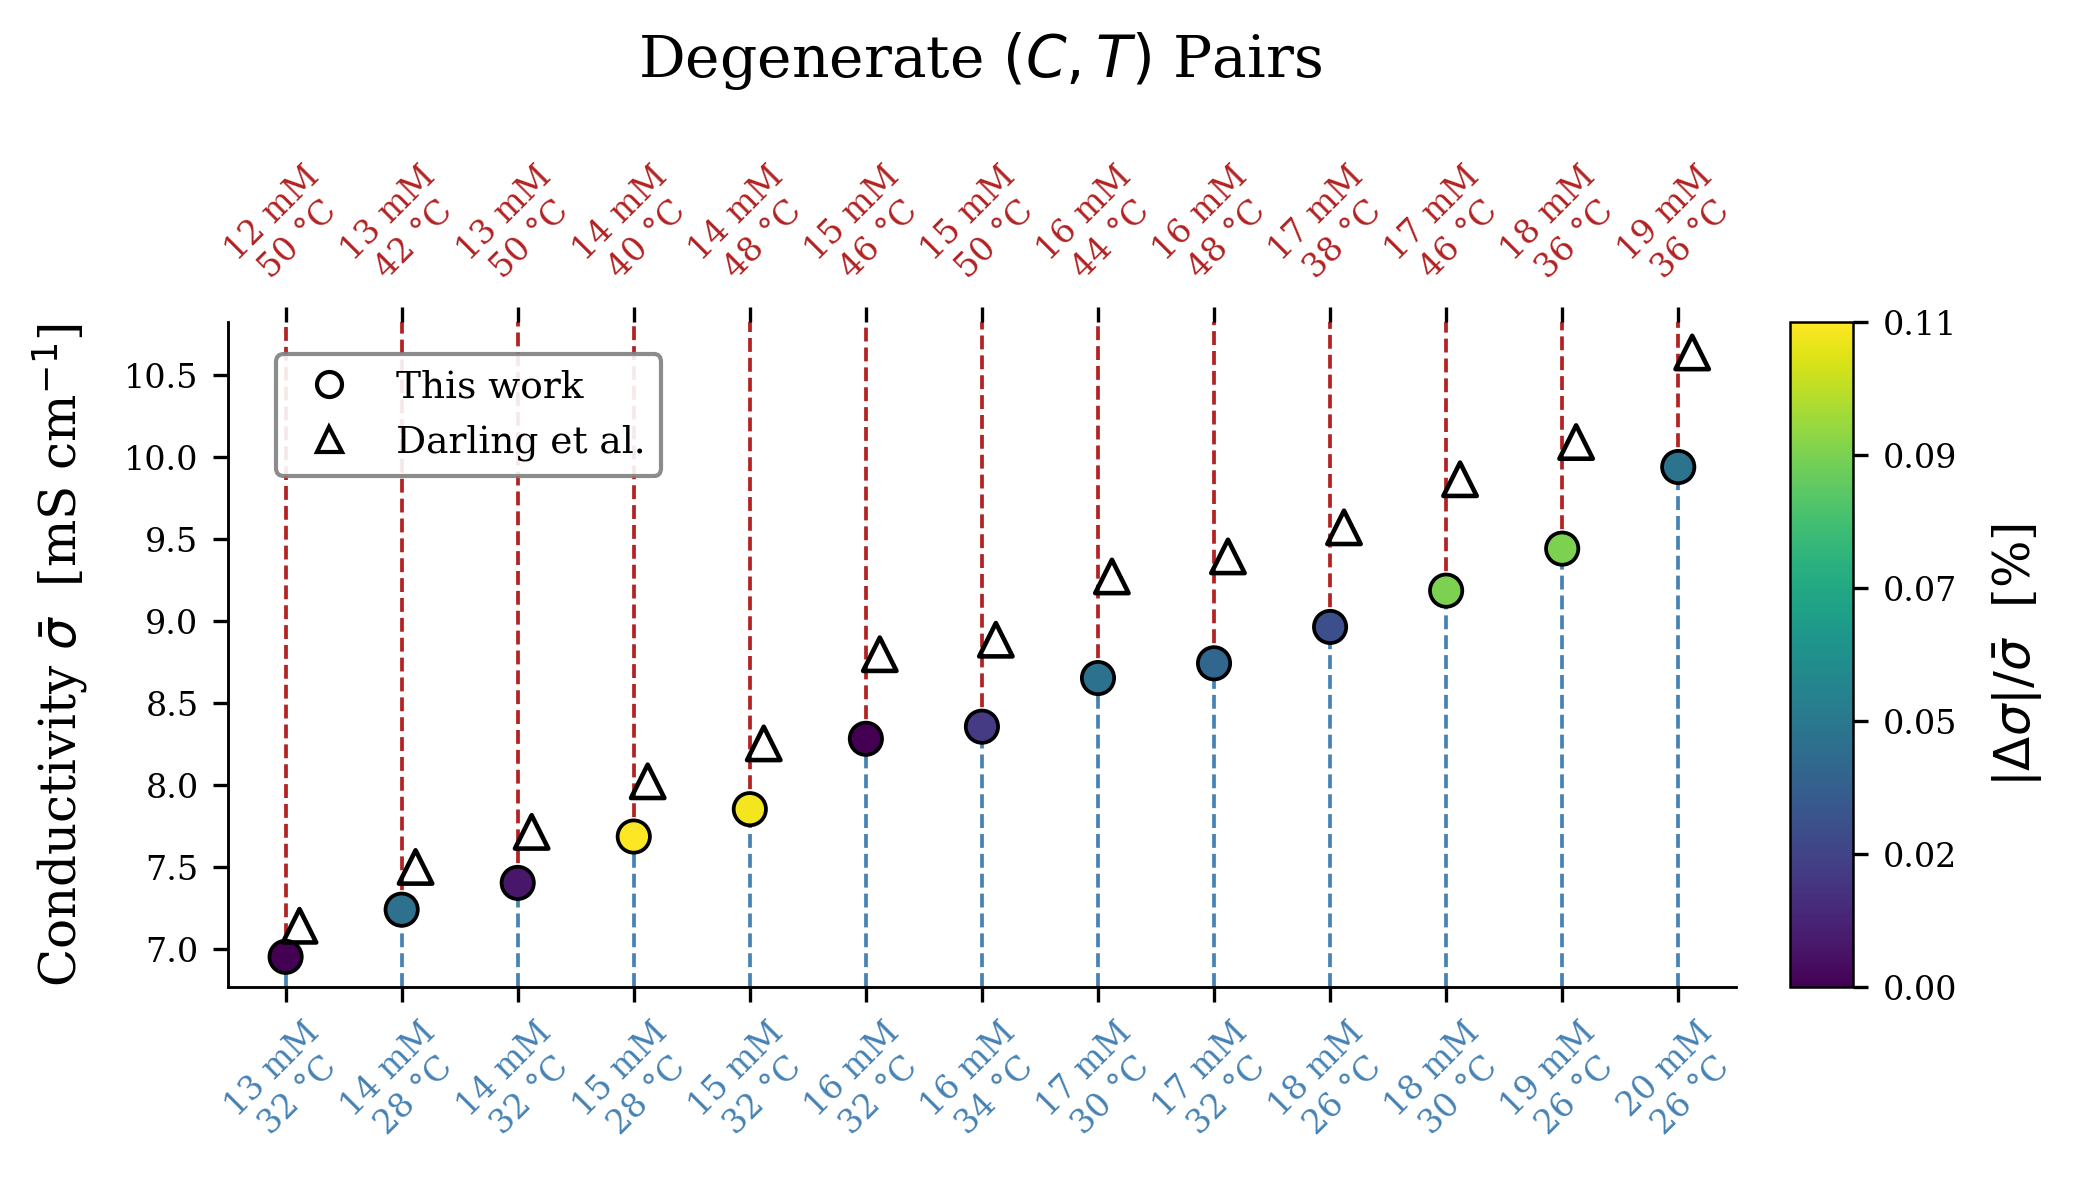

In [26]:
from pathlib import Path

# ---------------------------------------------------------------
#  Degenerate (C,T) Pairs — corrected mean vs Darling mean
#  * Bottom ticks centered on data (fixes left-shift)
#  * Legend in boxed panel; black circle/triangle in legend
#  * Points: corrected = colormap fill with black edge; Darling = hollow black triangle
# ---------------------------------------------------------------
CSV = r"/Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/results/degenerate_σ_abs<0.01_from_sigma_corr_maxerr7_ctdiff.csv"
OUT_DIR = Path(r"/Users/hosseinostovar/Desktop/BACKUP/Data/NPG-500mM-H2SO4-whole/plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

THRESH = 0.005   # only used in the filename tag

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 9,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.linewidth": 0.6,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 12,
    "axes.labelpad": 8,
})

# ------------------ 1) load & parse ------------------
df = pd.read_csv(CSV)
df.columns = [c.strip() for c in df.columns]

def _parse_ct(s):
    m = re.match(r"\s*(\d+)\s*mM,\s*(\d+)\s*C", str(s))
    return (int(m.group(1)), int(m.group(2))) if m else (np.nan, np.nan)

df[["C1","T1"]] = df["conc_T #1"].apply(lambda s: pd.Series(_parse_ct(s)))
df[["C2","T2"]] = df["conc_T #2"].apply(lambda s: pd.Series(_parse_ct(s)))

s1 = df["σ #1 (mS/cm)"].astype(float).to_numpy()
s2 = df["σ #2 (mS/cm)"].astype(float).to_numpy()
s_avg = (s1 + s2) / 2.0
rel_dev_pct = 100.0 * np.where(s_avg != 0, np.abs(s1 - s2) / s_avg, np.nan)  # color metric

have_darling = ("σ_pred #1 (mS/cm)" in df.columns) and ("σ_pred #2 (mS/cm)" in df.columns)
if have_darling:
    s1_pred = df["σ_pred #1 (mS/cm)"].astype(float).to_numpy()
    s2_pred = df["σ_pred #2 (mS/cm)"].astype(float).to_numpy()
    s_avg_pred = (s1_pred + s2_pred) / 2.0
else:
    s_avg_pred = None

# ------------------ 2) stable order for display ------------------
order = np.argsort(s_avg)
df = df.iloc[order].reset_index(drop=True)
s_avg = s_avg[order]
rel_dev_pct = rel_dev_pct[order]
if have_darling: s_avg_pred = s_avg_pred[order]

# ------------------ 3) plot ------------------
x = np.arange(len(df))
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# *** fix alignment: set limits & ticks before labeling; labels CENTERED ***
ax.set_xlim(-0.5, len(df) - 0.5)
ax.set_xticks(x)

# corrected mean (colored by relative deviation), black edge
sc = ax.scatter(
    x, s_avg,
    c=rel_dev_pct, cmap="viridis",
    s=60, zorder=3,
    edgecolors="black", linewidths=0.9,
)

# Darling overlay: hollow black triangles, slight x-offset
if have_darling:
    ax.scatter(
        x + 0.12, s_avg_pred,
        marker="^", facecolors="none",
        edgecolors="black", linewidths=1.1,
        s=64, zorder=3,
    )

# bottom tick labels (C1,T1) — CENTER aligned to tick
ax.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C1"], df["T1"])],
    rotation=45, ha="center", color="steelblue",
)

# top axis for (C2,T2), also centered
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x)
ax_top.set_xticklabels(
    [f"{c} mM\n{t} °C" for c, t in zip(df["C2"], df["T2"])],
    rotation=45, ha="center", color="firebrick",
)
ax_top.xaxis.set_ticks_position("top")

ax.set_ylabel(r"Conductivity $\bar{\sigma}$  [mS cm$^{-1}$]")

# vertical guides (based on corrected means)
ymin, ymax = ax.get_ylim()
for xi, yi in zip(x, s_avg):
    ax.plot([xi, xi], [ymin, yi], ls="--", lw=0.9, color="steelblue",  zorder=0)
    ax.plot([xi, xi], [yi, ymax], ls="--", lw=0.9, color="firebrick", zorder=0)
ax.set_ylim(ymin, ymax)

ax.set_title("Degenerate $(C,T)$ Pairs ", fontsize=14, pad=20)

# ------------------ legend in a boxed panel (black markers) ------------------
legend_handles = [
    Line2D([0],[0], marker="o", color="black", markerfacecolor="none", lw=0, label="This work "),
    Line2D([0],[0], marker="^", color="black", markerfacecolor="none", lw=0, label="Darling et al."),
]
ax.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),
    frameon=True, framealpha=0.9,
    facecolor="white", edgecolor="0.5",
)

# layout before colorbar
fig.tight_layout()

# ------------------ colorbar outside, same height feel ------------------
CBAR_WIDTH, CBAR_PAD, CBAR_HFRAC = 0.035, 0.03, 1.0
pos = ax.get_position()
cax = fig.add_axes([pos.x1 + CBAR_PAD, pos.y0 + (pos.height*(1-CBAR_HFRAC))/2,
                    CBAR_WIDTH, pos.height*CBAR_HFRAC])
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label(r'$|\Delta \sigma| / \bar{\sigma}$  [%]')

vmin, vmax = np.nanmin(rel_dev_pct), np.nanmax(rel_dev_pct)
if not np.isfinite(vmin): vmin = 0.0
if not np.isfinite(vmax): vmax = 1.0
ticks = np.linspace(vmin, vmax, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.2f}" for t in ticks])

# ------------------ save ------------------
fname = OUT_DIR / f"degenerate_sigma_pairs_thresh{THRESH:.3f}Ω_relDev_corrected_vs_Darling.png"
fig.savefig(fname, dpi=300, bbox_inches="tight")
plt.show()
